# Practicum II - Movie Database Applicaton
### Collaborators: Abasamia Akpan, Rebecca Brent and Alessia Pizzoccheri

This Notebook provides context, documentation and sample code for a Database Application using IMBd datasets; for clarity, this document has been divided into the following sections:

### 1. Introduction
### 2. Assumptions
### 3. Logical Models
### 4. Database and Relations Definition¶
### 1. Introduction
#### 1.1. Looking at the data
In this section, we analyze and deconstruct the various data sets found on the IMBd page; data is organized in seven TSV files, specifically:

Title AKAs
Title Basics
Title Episodes
Title Ratings
Title Crew
Name Basics
Title Principles Our first step is to establish relationships between each data set and identify a primary key (PK) on each table. Since no information was provided regarding the role of columns, we devised a solution to find unique identifiers within each data set; that is, for each table we compare the total number of rows against the total number of unique values for a given column.
1.2 Establishing PKs

In [7]:
import pandas as pd
import numpy as np
import os
import sys
import pip

from tqdm import tqdm
import mysql.connector
from mysql.connector import Error
# install packages used below if not already installed -- not necessary to run this chunk if they are
pip.main(['install','prettytable'])
pip.main(['install','mysql-connector-python'])
pip.main(['install','tqdm'])
pip.main(['install','pymysql'])
pip.main(['install', 'tkinter'])

host_name = "localhost"
user_name = "root"
database = "imdb"
password = input("Please enter the password for connecting to SQL (root): ")

BATCH_SIZE = 10000

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
ERROR: Could not find a version that satisfies the requirement tkinter (from versions: none)
ERROR: No matching distribution found for tkinter


Please enter the password for connecting to SQL (root): new_password


In [8]:
def create_connection_nodb():
    """ create a connection to mysql host
    :param host_name: string host name (ie. "localhost")
    :param user_name: string username (ie. "root")
    :param user_password: string the password to connect to mysql
    :return: connection object
    """
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=password
        )
        print("Connection to MySQL DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

def create_database(connection):
    """ create a database 
    :param connection: Connection object
    :param db_name: name of database in form of string
    :return:
    """
    cursor = connection.cursor()
    try:
        query = "CREATE DATABASE IF NOT EXISTS " + database
        cursor.execute(query)
        print("Database created successfully")
    except Error as e:
        print(f"The error '{e}' occurred")
        
def create_connection():
    """ create a connection to the (possibly newly created) database
    :param host_name: string host name (ie. "localhost")
    :param user_name: string username (ie. "root")
    :param user_password: string the password to connect to mysql
    :param db_name: string name of database 
    :return: connection object
    """
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=password,
            database=database
        )
        print("Connection to MySQL DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
        table_name = create_table_sql.split(" ")[5].split("(")[0]
        print("Successfully created table: " + table_name)
    except Error as e:
        print(e)
        
def main():
    
    create_table_titlebasics = """CREATE TABLE IF NOT EXISTS titlebasics(
                                    tconst VARCHAR(11) PRIMARY KEY,
                                    titleType TEXT,
                                    primaryTitle MEDIUMTEXT,
                                    originalTitle MEDIUMTEXT,
                                    isAdult BOOLEAN,
                                    startYear DATE,
                                    endYear DATE,
                                    runTimeMinutes TIME)"""
    
    create_table_titleratings = """CREATE TABLE IF NOT EXISTS titleratings(
                                    tconst VARCHAR(11) PRIMARY KEY,
                                    averageRating FLOAT,
                                    numVotes INT,
                                    FOREIGN KEY (tconst) REFERENCES titlebasics(tconst))"""


    create_table_titleepisodes = """CREATE TABLE IF NOT EXISTS titleepisodes(
                                    tconst VARCHAR(11) PRIMARY KEY,
                                    seasonNumber INT,
                                    episodeNumber INT,
                                    parentTconst VARCHAR(11),
                                    FOREIGN KEY (parentTconst) REFERENCES titlebasics(tconst))"""


    create_table_namebasics = """CREATE TABLE IF NOT EXISTS namebasics(
                                nconst VARCHAR(11) PRIMARY KEY,
                                primaryname TEXT,
                                birthyear DATE,
                                deathyear DATE,
                                noofmovies INT,
                                age INT)"""
    
    
    create_table_genres = """CREATE TABLE IF NOT EXISTS genres(
                                genreID INT AUTO_INCREMENT  PRIMARY KEY,
                                genre VARCHAR(256) UNIQUE)"""
    
    create_table_primaryprofession = """CREATE TABLE IF NOT EXISTS primaryprofession(
                                primaryprofessionID INT AUTO_INCREMENT PRIMARY KEY,
                                profession VARCHAR(256) UNIQUE)"""
    
 
    
    
    create_table_genretitlebasics = """CREATE TABLE IF NOT EXISTS genretitlebasics(
                                titlebasicsID VARCHAR(11),
                                genreID INT,
                                PRIMARY KEY (titlebasicsID, genreID),
                                FOREIGN KEY (titlebasicsID) REFERENCES titlebasics(tconst),
                                FOREIGN KEY (genreID) REFERENCES genres(genreID))"""
    

    
    create_table_primaryprofessiontitlenames = """CREATE TABLE IF NOT EXISTS primaryprofessiontitlenames(
                                primaryprofessionid INT,
                                namebasicsid VARCHAR(11),
                                PRIMARY KEY (primaryprofessionid, namebasicsid),
                                FOREIGN KEY (primaryprofessionid) REFERENCES primaryprofession(primaryprofessionid),
                                FOREIGN KEY (namebasicsid) REFERENCES namebasics(nconst))"""
    
    create_table_knownfortitles = """CREATE TABLE IF NOT EXISTS knownfortitles(
                                namebasicsid VARCHAR(11),
                                knownfortitle VARCHAR(11),
                                PRIMARY KEY (namebasicsid, knownfortitle),
                                FOREIGN KEY (namebasicsid) REFERENCES namebasics(nconst),
                                FOREIGN KEY (knownfortitle) REFERENCES titlebasics(tconst))"""
    
    
    conn = create_connection_nodb()
    
    # create database object if not already created and then connect the cursor to it
    if conn is not None:
        create_database(conn)
        conn = create_connection()
        
        # create tables
        if conn is not None:
            
            # create Title Basics table
            create_table(conn, create_table_titlebasics)

            # create Title Ratings table
            create_table(conn, create_table_titleratings)
            
            # create title episodes table
            create_table(conn, create_table_titleepisodes)
            
            # create name basics table
            create_table(conn, create_table_namebasics)
            
            # create genres table
            create_table(conn,create_table_genres)
            
            # create known for titles table
            create_table(conn,create_table_knownfortitles)
            
            # create primary profession table
            create_table(conn,create_table_primaryprofession)
            
            # create genre title basics table
            create_table(conn, create_table_genretitlebasics)

            # create Primary Profession Title Names table
            create_table(conn, create_table_primaryprofessiontitlenames)
            
                
        else:
            print("Error! cannot create the database connection.")
    
    else:
        print("Error! Cannot create the MySQL connection.")
    
    


if __name__ == '__main__':
    main()



Connection to MySQL DB successful
Database created successfully
Connection to MySQL DB successful
Successfully created table: titlebasics
Successfully created table: titleratings
Successfully created table: titleepisodes
Successfully created table: namebasics
Successfully created table: genres
Successfully created table: knownfortitles
Successfully created table: primaryprofession
Successfully created table: genretitlebasics
Successfully created table: primaryprofessiontitlenames


## SQL communication helper

In [9]:
import sqlalchemy
database_connection = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                               format(user_name, password, 
                                                      host_name, database))

In [10]:
## Helper Functions

In [11]:
def load_dataframe(data_frame,table_name):
    data_frame_new=data_frame
    
    data_frame_new.to_sql(table_name,con=database_connection, if_exists='append',index=False)
    
    return 

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [12]:
def preprocess_dataframe_parsing(data_frame, column_name, final_column_name):
    
    data_frame=data_frame.to_frame()
    data_frame=data_frame.assign(name=data_frame[column_name].str.split(","))
    #type(x.iloc[0,1])
    data_frame=data_frame.explode('name')
    data_preprocessed_unique= pd.DataFrame(data_frame.name.unique())
    data_preprocessed_unique_column_rename=data_preprocessed_unique.rename(columns={0:final_column_name})
    
    return data_preprocessed_unique_column_rename

## Title Basics

In [44]:
# read title basic file
title_basics = pd.read_csv('title.basics.tsv', delimiter='\t',encoding='utf-8')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [14]:
def preprocess_dataframe_title_basics(data_frame):
    title_basics_new_series=data_frame

    b = pd.to_datetime(title_basics_new_series['runtimeMinutes'], errors='coerce', format='%M')

    b.to_frame().runtimeMinutes
    df_1 = pd.DataFrame(dict(time_stamps = b)) 

    df_1['runtimeMinutes'] = df_1['time_stamps'].dt.minute
    title_basics_new_series=title_basics_new_series.drop(['runtimeMinutes'],axis=1)
    title_basics_new_series['runtimeMinutes']=df_1['runtimeMinutes']
    
    title_basics_new_frame_transpose=title_basics_new_series.astype({'isAdult': 'int32'})
    
    title_basics_new_frame_transpose["isAdult"]=title_basics_new_frame_transpose.isAdult.mask(title_basics_new_frame_transpose.isAdult > 1,1)

    title_basics_new_frame_transpose['startYear']= pd.to_datetime(title_basics.startYear, errors='coerce', format='%Y')

    
    title_basics_new_frame_transpose['endYear']= pd.to_datetime(title_basics.endYear, errors='coerce', format='%Y')
    title_basics_new_frame_transpose=title_basics_new_frame_transpose.drop(['genres'],axis=1)
  

    title_basics_new_frame_transpose_new=title_basics_new_frame_transpose.rename(columns={"runtimeMinutes": "runTimeMinutes"})

    return title_basics_new_frame_transpose_new

title_basics_preprocessed=preprocess_dataframe_title_basics(title_basics)

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [15]:
length = len(title_basics_preprocessed)//BATCH_SIZE+1

for chunk in tqdm(batch(title_basics_preprocessed,BATCH_SIZE),total=length):
    load_dataframe(chunk,'titlebasics')

100%|██████████| 730/730 [03:54<00:00,  3.11it/s]


In [223]:
genres_preprocessed = preprocess_dataframe_parsing(title_basics.genres, "genres", "genre")
genres_preprocessed.dropna(inplace=True)
genres_preprocessed = genres_preprocessed[genres_preprocessed.genre != '\\N']

In [54]:
length = len(genres_preprocessed)//BATCH_SIZE+1

for chunk in tqdm(batch(genres_preprocessed,BATCH_SIZE),total=length):
    load_dataframe(chunk,'genres')

100%|██████████| 1/1 [00:00<00:00, 36.34it/s]


In [224]:
# Create dictionary of genres with their id for mapping the genres in the association table
conn = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=password,
            database=database
        )
c = conn.cursor()
c.execute("SELECT * FROM genres")
records = c.fetchall()
genre_dict = {}
for row in records:
    genre_dict.update({row[1]:row[0]})
c.close()
conn.close()

In [225]:
def preprocess_dataframe__for_genres(data_frame):
    df = data_frame
    lst_col = 'genres'
  
    df = df.drop(['titleType'], axis=1)
    df = df.drop(['primaryTitle'], axis=1)
    df = df.drop(['originalTitle'], axis=1)
    df=df.drop(['isAdult'], axis=1)
    df=df.drop(['startYear'], axis=1)
    df=df.drop(['endYear'], axis=1)
    df=df.drop(['runtimeMinutes'],axis=1)
    
    x = df.assign(**{lst_col:df[lst_col].str.split(',')})
    genres_df = x.explode('genres')

    return genres_df

df =  preprocess_dataframe__for_genres(title_basics)
df = df[df.genres != '\\N']
df = df.replace({"genres":genre_dict})
df = df.rename(columns={"tconst" : "titlebasicsID", "genres" : "genreID"})

In [226]:
df

,titlebasicsID,genreID
0,tt0000001,1.0
0,tt0000001,2.0
1,tt0000002,3.0
1,tt0000002,2.0
2,tt0000003,3.0
...,...,...
7292278,tt9916852,17.0
7292279,tt9916856,2.0
7292280,tt9916880,3.0
7292280,tt9916880,4.0


In [228]:
df_new=df.dropna(inplace=True)

In [229]:
length = len(df_new)//BATCH_SIZE+1

for chunk in tqdm(batch(df_new,BATCH_SIZE),total=length):
    load_dataframe(chunk,'genretitlebasics')

100%|██████████| 1102/1102 [04:15<00:00,  4.31it/s]


In [21]:
del df
del title_basics
del genres_preprocessed
del genre_dict
# title_basics_preprocessed is used later on so will not delete until after

## Title ratings

In [344]:
# read data from title ratings file
title_ratings = pd.read_csv('title.ratings.tsv', delimiter='\t',encoding='utf-8')
title_ratings

,tconst,averageRating,numVotes
0,tt0000001,5.6,1656
1,tt0000002,6.1,201
2,tt0000003,6.5,1369
3,tt0000004,6.2,122
4,tt0000005,6.2,2151
...,...,...,...
1086697,tt9916580,7.2,5
1086698,tt9916690,6.6,5
1086699,tt9916720,6.0,65
1086700,tt9916766,6.9,14


In [345]:
def preprocess_dataframe_title_ratings(data_frame):
    title_ratings_new_series=data_frame
    
    title_ratings_new_frame_avg_rating= title_ratings_new_series.astype({'averageRating': 'float'})
    title_ratings_new_frame_avg_rating= title_ratings_new_series.astype({'numVotes': 'int32'})
    #title_ratings_preprocessed.tconst = title_ratings_preprocessed.tconst.mask(~title_ratings_preprocessed.tconst.isin(title_basics_preprocessed.tconst),None)
    return title_ratings_new_frame_avg_rating

title_ratings_preprocessed=preprocess_dataframe_title_ratings(title_ratings)

In [347]:
length = len(title_ratings_preprocessed)//BATCH_SIZE+1

for chunk in tqdm(batch(title_ratings_preprocessed,BATCH_SIZE),total=length):
    load_dataframe(chunk,'titleratings')

100%|██████████| 109/109 [00:47<00:00,  2.30it/s]


In [24]:
# delete now unrequired tables to free memory
del title_ratings
del title_ratings_preprocessed

## Title Episodes


In [25]:
# read title episodes data
title_episodes = pd.read_csv('title.episode.tsv', delimiter='\t',encoding='utf-8')
title_episodes

,tconst,parentTconst,seasonNumber,episodeNumber
0,tt0041951,tt0041038,1,9
1,tt0042816,tt0989125,1,17
2,tt0042889,tt0989125,\N,\N
3,tt0043426,tt0040051,3,42
4,tt0043631,tt0989125,2,16
...,...,...,...,...
5252722,tt9916846,tt1289683,3,18
5252723,tt9916848,tt1289683,3,17
5252724,tt9916850,tt1289683,3,19
5252725,tt9916852,tt1289683,3,20


In [26]:
def preprocess_dataframe_title_episodes(data_frame):
    title_episodes_new_series=data_frame
    title_episodes_coerce_seasonNum = pd.to_numeric(title_episodes_new_series['seasonNumber'], errors='coerce')
    title_episodes_coerce_episodeNum = pd.to_numeric(title_episodes_new_series['episodeNumber'], errors='coerce')

    df_1 = pd.DataFrame(dict(test_column_1 = title_episodes_coerce_seasonNum)) 
    df_2 = pd.DataFrame(dict(test_column_2 = title_episodes_coerce_episodeNum)) 

    df_1['seasonNumber'] = df_1['test_column_1']
    df_2['episodeNumber'] = df_2['test_column_2']
    
    title_episodes_new_frame=title_episodes_new_series.drop(['seasonNumber'],axis=1)
    title_episodes_new_frame=title_episodes_new_series.drop(['episodeNumber'],axis=1)
    
    title_episodes_new_frame['seasonNumber']=df_1['seasonNumber']
    title_episodes_new_frame['episodeNumber']=df_2['episodeNumber']
    return title_episodes_new_frame

title_episodes_preprocessed = preprocess_dataframe_title_episodes(title_episodes)

# removes any episodes that do not have a corresponding key in title basics table 
title_episodes_preprocessed=title_episodes_preprocessed[
    title_episodes_preprocessed.parentTconst.isin(title_basics_preprocessed.tconst)]

In [27]:
# load dataframe into corresponding SQL table
length = len(title_episodes_preprocessed)//BATCH_SIZE+1

for chunk in tqdm(batch(title_episodes_preprocessed,BATCH_SIZE),total=length):
    load_dataframe(chunk,'titleepisodes')

100%|██████████| 526/526 [03:42<00:00,  2.36it/s]


In [28]:
del title_episodes_preprocessed
del title_episodes

## Name Basics

In [70]:
name_basics = pd.read_csv('name.basics.tsv', delimiter='\t',encoding='utf-8')
name_basics

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0031983,tt0072308,tt0053137,tt0050419"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0037382,tt0117057,tt0038355,tt0071877"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0054452,tt0059956,tt0057345"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0078723,tt0072562,tt0080455,tt0077975"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0060827,tt0050976,tt0083922,tt0050986"
...,...,...,...,...,...,...
10464396,nm9993714,Romeo del Rosario,\N,\N,"animation_department,art_department",tt2455546
10464397,nm9993716,Essias Loberg,\N,\N,NaN,\N
10464398,nm9993717,Harikrishnan Rajan,\N,\N,cinematographer,tt8736744
10464399,nm9993718,Aayush Nair,\N,\N,cinematographer,\N


In [30]:
def preprocess_dataframe_name_basics(data_frame):
    name_basics_new_series=data_frame
    name_basics_new_series=name_basics_new_series.drop(['primaryProfession', 'knownForTitles'],axis=1)
    
    name_basics_new_series['birthYear']= pd.to_datetime(name_basics_new_series.birthYear, errors='coerce', format='%Y')

    
    name_basics_new_series['deathYear']= pd.to_datetime(name_basics_new_series.deathYear, errors='coerce', format='%Y')
    
    return name_basics_new_series

name_basics_preprocessed = preprocess_dataframe_name_basics(name_basics)

name_basics_preprocessed["noofmovies"] = ""
name_basics_preprocessed["age"] = ""

name_basics_preprocessed_new= pd.to_numeric(name_basics_preprocessed['noofmovies'], errors='coerce')
name_basics_preprocessed_new = pd.to_numeric(name_basics_preprocessed['age'], errors='coerce')

df_1 = pd.DataFrame(dict(test_column_1 = name_basics_preprocessed_new)) 
df_2 = pd.DataFrame(dict(test_column_2 = name_basics_preprocessed_new)) 

df_1['noofmovies'] = df_1['test_column_1']
df_2['age'] = df_2['test_column_2']

name_basics_preprocessed['noofmovies']=df_1['noofmovies']
name_basics_preprocessed['age']=df_2['age']

del df_1
del df_2

In [31]:
# load dataframe into corresponding SQL table
length = len(name_basics_preprocessed)//BATCH_SIZE+1

for chunk in tqdm(batch(name_basics_preprocessed,BATCH_SIZE),total=length):
    load_dataframe(chunk,'namebasics')

100%|██████████| 1047/1047 [04:16<00:00,  4.09it/s]


In [86]:
profession_preprocessed=preprocess_dataframe_parsing(name_basics.primaryProfession, "primaryProfession", "profession")
profession_preprocessed.dropna(inplace=True)

In [33]:
# load dataframe into corresponding SQL table
length = len(profession_preprocessed)//BATCH_SIZE+1

for chunk in tqdm(batch(profession_preprocessed,BATCH_SIZE),total=length):
    load_dataframe(profession_preprocessed,'primaryprofession')

100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


In [34]:
# Create dictionary of professions with their id for mapping the professions in the association table
conn = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=password,
            database=database
        )
c = conn.cursor()
c.execute("SELECT * FROM primaryprofession")
records = c.fetchall()
prof_dict = {}
for row in records:
    prof_dict.update({row[1]:row[0]})
c.close()
conn.close()

In [35]:
def preprocess_dataframe_for_primaryprof(data_frame):
    df = data_frame
    lst_col = 'primaryProfession'
  
    df = df.drop(['primaryName'], axis=1)
    df = df.drop(['birthYear'], axis=1)
    df = df.drop(['deathYear'], axis=1)
    df=df.drop(['knownForTitles'], axis=1)

    
    x = df.assign(**{lst_col:df[lst_col].str.split(',')})
    primaryprof_df = x.explode('primaryProfession')

    return primaryprof_df

df =  preprocess_dataframe_for_primaryprof(name_basics)

df=df[df.primaryProfession.isin(profession_preprocessed.profession)]
df.dropna(inplace=True)
df = df.replace({"primaryProfession":prof_dict})
# delete dictionary because no longer needed
del prof_dict
# rename columns to match the SQL variables for loading
df = df.rename(columns={"nconst" : "namebasicsID", "primaryProfession" : "primaryprofessionID"})

In [36]:
# load dataframe into corresponding SQL table
length = len(df)//BATCH_SIZE+1

for chunk in tqdm(batch(df,BATCH_SIZE),total=length):
    load_dataframe(chunk,'primaryprofessiontitlenames')

100%|██████████| 1143/1143 [05:57<00:00,  3.20it/s]


In [37]:
def preprocess_dataframe_for_knownfortitles(data_frame):
    df = data_frame
    lst_col = 'knownForTitles'
  
    df = df.drop(['primaryName'], axis=1)
    df = df.drop(['birthYear'], axis=1)
    df = df.drop(['deathYear'], axis=1)
    df=df.drop(['primaryProfession'], axis=1)
    
    x = df.assign(**{lst_col:df[lst_col].str.split(',')})
    kft_df = pd.DataFrame({
                      col:np.repeat(x[col].values, x[lst_col].str.len())
                      for col in x.columns.difference([lst_col])
                      }).assign(**{lst_col:np.concatenate(x[lst_col].values)})[x.columns.tolist()]

    return kft_df

kft_df =  preprocess_dataframe_for_knownfortitles(name_basics)


kft_df = kft_df[kft_df.knownForTitles != '\\N']
kft_df=kft_df[kft_df.knownForTitles.isin(title_basics_preprocessed.tconst)]
kft_df = kft_df.rename(columns={"nconst" : "namebasicsID", "knownForTitles" : "knownfortitle"})

In [38]:
# load dataframe into corresponding SQL table
length = len(kft_df)//BATCH_SIZE+1

for chunk in tqdm(batch(kft_df,BATCH_SIZE),total=length):
    load_dataframe(chunk,'knownfortitles')

100%|██████████| 1643/1643 [17:48<00:00,  1.54it/s]


In [39]:
# delete all dataframes out of memory since all information is now in SQL DB Tables
del kft_df
del df
del name_basics_preprocessed
#del profession_preprocessed
#del name_basics
del title_basics_preprocessed

## Question 5

In [40]:
conn = create_connection("localhost", "root", "new_password", "imdb")
c = conn.cursor()

operation = """SELECT COUNT(KT.knownfortitle)
                FROM knownforTitles AS KT 
                WHERE KT.knownfortitle IN (SELECT tconst
                                            FROM titlebasics AS TB 
                                            WHERE TB.titletype = 'Movie')
                GROUP BY namebasicsID
                LIMIT 5"""

for result in c.execute(operation, multi=True):
    if result.with_rows:
        print("Rows produced by statement '{}':".format(
          result.statement))
        print(result.fetchall())
    else:
        print("Number of rows affected by statement '{}': {}".format(
          result.statement, result.rowcount))


TypeError: create_connection() takes 0 positional arguments but 4 were given

## Question 6

## Question 7 

#### RUN ONLY ONCE. WILL FAIL ON SECOND ATTEMPT. CANNOT CREATE THE SAME VIEW TWICE

In [348]:
with database_connection.connect() as con:

    
        rs = con.execute("""CREATE VIEW new_view AS SELECT primaryname,CASE WHEN deathyear IS NOT NULL
                        THEN TRUE ELSE FALSE END AS isalive,age,noofmovies FROM namebasics n
                        Inner Join primaryprofessiontitlenames pptn on n.nconst=pptn.namebasicsid 
                        Inner Join primaryprofession pp on pptn.primaryprofessionid=pp.primaryprofessionID 
                        WHERE pp.profession="actress" or pp.profession="actor";""")
        con.close()

    

## Alive: 1 Dead: 0

In [349]:
with database_connection.connect() as con:
        
    alive_or_dead_list = pd.read_sql('SELECT * from new_view', database_connection.connect())

In [350]:
alive_or_dead_list

,primaryname,isalive,age,noofmovies
0,Fred Astaire,1,121.0,None
1,John Belushi,1,71.0,None
2,Ingmar Bergman,1,102.0,None
3,Humphrey Bogart,1,121.0,None
4,Marlon Brando,1,96.0,None
...,...,...,...,...
3875455,Cheryl Clark,0,NaN,None
3875456,Yukari Funaki,0,NaN,None
3875457,Hiroko Ide,0,NaN,None
3875458,Anketa Maharana,0,NaN,None


## QUESTION 8

In [351]:
no_of_seasons = pd.read_sql("""SELECT tb.originalTitle, COUNT(DISTINCT(te.seasonNumber))
                 as noOfSeasons FROM titleepisodes AS te 
                 INNER JOIN titlebasics tb on te.parentTconst=tb.tconst 
                 GROUP BY tb.originalTitle;""", database_connection.connect())


In [352]:
no_of_seasons

,originalTitle,noOfSeasons
0,_tiktok_th0ts,0
1,-Dash,2
2,-Less,1
3,:30 Seconds,1
4,:Dryvrs,1
...,...,...
136973,Zyliara ASMR,0
136974,ZZ Series,0
136975,Zzuber,1
136976,ZZZap!,10


In [353]:
no_of_seasons.describe()

,noOfSeasons
count,136978.000000
mean,1.577348
std,2.516571
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,267.000000


[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'NoOfSeasons'),
 Text(0.5, 1.0, 'NoOfSeasons Frequency')]

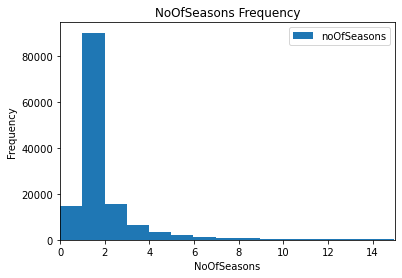

In [354]:
no_of_seasons_plot=no_of_seasons.plot.hist(bins=268, xlim=(0,15))
no_of_seasons_plot.set(xlabel='NoOfSeasons', ylabel='Frequency', title='NoOfSeasons Frequency')

## QUESTION 9

### Generate Random String

In [71]:
import string
import random

def get_random_string(length):

    letters = string.ascii_lowercase
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

### Generate Random nconst

In [79]:
def generate_nconst_string_id(table_name,length):
    
    table_id=set(table_name.nconst)
    #name_basicsid

    while True:
        new_id=get_random_string(length)
        if new_id not in table_id:
            return new_id

### Generate Random tconst 

In [80]:
def generate_tconst_string_id(table_name,length):
    
    table_id=set(table_name.tconst)
    #name_basicsid

    while True:
        new_id=get_random_string(length)
        if new_id not in table_id:
            return new_id

### Generate random primaryprofessionid

In [365]:
def generate_int_id(table):
    new_id=len(table)+20
    
    return new_id

In [132]:
new_id=generate_string_id(name_basics,7)

new_id

'bolmdjz'

## Stored procedure in MySQL-Run it on your machine to test the next sets of code

In [ ]:
# DELIMITER $$
#           CREATE PROCEDURE ADD_ACTOR(
#                 IN new_name_basics_string_id VARCHAR(11),
#                 IN new_title_basics_string_id VARCHAR(11),
#                 IN new_primary_profession_int_id INT,
#                 IN primaryName TEXT,
#                 IN profession VARCHAR(32),
#                 IN BirthYear TEXT,
#                 IN DeathYear TEXT,
#                 IN Age INT,
#                 IN NoofMovies INT,
#                 IN titletype TEXT,
#                 IN primarytitle MEDIUMTEXT,
#                 IN originaltitle MEDIUMTEXT,
#                 IN isAdult BOOLEAN,
#                 IN StartYear TEXT,
#                 IN EndYear TEXT,
#                 IN runTimeMinutes TIME,


#             ) BEGIN
#                 START TRANSACTION;
#                 INSERT INTO namebasics (nconst, primaryname, birthyear, deathyear,age,noofmovies) 
#                     VALUES (new_name_basics_string_id, primaryName, STR_TO_DATE(BirthYear,'%d-%m-%Y'), STR_TO_DATE(DeathYear,'%d-%m-%Y'),Age,NoofMovies);
#                 INSERT INTO titlebasics (tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes)
#                     VALUES (new_title_basics_string_id,titletype,primarytitle,originaltitle,isAdult,STR_TO_DATE(StartYear,'%d-%m-%Y'),STR_TO_DATE(EndYear,'%d-%m-%Y'),runTimeMinutes);
#                 INSERT INTO knownfortitles (namebasicsid,knownfortitle)
#                     VALUES(new_name_basics_string_id,new_title_basics_string_id);
#                 INSERT INTO primaryprofessiontitlenames (primaryprofessionid,namebasicsid)
#                     VALUES(new_primary_profession_int_id,new_name_basics_string_id);
#                COMMIT WORK;
#             END$$
#     DELIMITER ;


## Stored Procedure is called in this function

In [410]:
new_name_basics_string_id=generate_nconst_string_id(name_basics,7)
new_title_basics_string_id=generate_tconst_string_id(title_basics,7)

In [411]:
def addActor(primaryName,profession,BirthYear,DeathYear,Age,NoOfMovies,titletype,primarytitle,originaltitle,isAdult,StartYear,EndYear,runtimeMinutes):

    new_primary_profession_int_id=2 #2 is actor id in primaryprofession table

    
    with database_connection.connect() as con:

        query_string=f"""CALL ADD_ACTOR('{new_name_basics_string_id}','{new_title_basics_string_id}','{new_primary_profession_int_id}','{primaryName}','{profession}','{BirthYear}','{DeathYear}','{Age}','{NoOfMovies}','{titletype}','{primarytitle}','{originaltitle}','{isAdult}','{StartYear}','{EndYear}','{runtimeMinutes}')"""


        actor_added = pd.read_sql(query_string,con)


    return actoradded


### ACTOR WAS ADDED-IGNORE THE ERROR. CALL STORED PROCEDURE DOES NOT RETURN ROWS HENCE THE ERROR

In [413]:
new_actor=addActor("RippleEffect","actor",'01-01-1993','29-06-2018',25,600,"FerrisMovieType","FerrisPrimaryMovieTitle","FerrisMovieOrginalTitle",0,"19-05-2004","09-05-2005",103)

ResourceClosedError: This result object does not return rows. It has been closed automatically.

In [416]:
new_actor_added = pd.read_sql(f"""SELECT * FROM namebasics WHERE primaryName='RippleEffect'""", database_connection.connect())

In [417]:
new_actor_added

,nconst,primaryname,birthyear,deathyear,noofmovies,age
0,uvweszn,RippleEffect,1993-01-01,2018-06-29,1,25


In [391]:
#from IPython.display import Image
#Image(filename='actor.png')

## QUESTION 10-Same Structure as 9

In [418]:
#   DELIMITER $$
#         CREATE PROCEDURE DELETE_ACTOR(
# 				IN new_name_basics_string_id VARCHAR(11),
# 				IN new_title_basics_string_id VARCHAR(11),
# 				IN new_primary_profession_int_id INT,
# 				IN profession VARCHAR(32)

#           ) BEGIN
#   			START TRANSACTION;
# 				DELETE FROM primaryprofessiontitlenames WHERE primaryprofessiontitlenames.primaryprofessionid=new_primary_profession_int_id;
#   				DELETE FROM primaryprofession WHERE primaryprofession.profession=profession;
#   				DELETE FROM knownfortitles WHERE knownfortitles.knownfortitle=new_title_basics_string_id;
#   				DELETE FROM namebasics WHERE namebasics.nconst=new_name_basics_string_id;
#  	COMMIT WORK;
#   	END$$
#   DELIMITER ;

In [427]:
def deleteActor(nbid,tbid):
    new_primary_profession_int_id=2
    cast_type='actor'


    with database_connection.connect() as con:



        query_string=f"""CALL DELETE_ACTOR('{nbid}','{tbid}','{new_primary_profession_int_id}','{cast_type}')"""
    
        actor_added = pd.read_sql(query_string,con)


    
    return actor_added

In [428]:
deleteActor(new_name_basics_string_id,new_title_basics_string_id)

ResourceClosedError: This result object does not return rows. It has been closed automatically.

In [429]:
new_actor_deleted = pd.read_sql(f"""SELECT * FROM namebasics WHERE primaryName='RippleEffect'""", database_connection.connect())
new_actor_deleted

,nconst,primaryname,birthyear,deathyear,noofmovies,age


## QUESTION 11

In [401]:
def retrieveActorNames():
    
    actor_retrieve = pd.read_sql(f"""SELECT DISTINCT subquery.primaryName,subquery.age FROM (SELECT primaryName,age, SUM(averageRating*numVotes)/SUM(numVotes) AS avgRating from namebasics as nb
                                    INNER JOIN knownfortitles ktr on nb.nconst=ktr.namebasicsid
                                    INNER JOIN titlebasics tb on ktr.knownfortitle=tb.tconst
                                    INNER JOIN titleratings tr on tb.tconst=tr.tconst
                                    WHERE tb.titleType='movie'
                                    GROUP BY primaryName,age) AS subquery
                                    WHERE avgRating > (SELECT SUM(averageRating*numVotes)/SUM(numVotes) FROM titleratings);""",database_connection.connect())
    
    return actor_retrieve

In [402]:
retrieveActorNames()

,primaryName,age
0,L. Frank Baum,164.0
1,Will Morrison,NaN
2,William Gillespie,NaN
3,B.S. Ingemann,231.0
4,Grigore Brezeanu,128.0
...,...,...
685685,Eko Bareko,NaN
685686,Dedi Reksawardhana,NaN
685687,Novryanto T. Mahendra,NaN
685688,Adhi Purwanto,NaN
